# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.5 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=f59d6c413856df9a29e79bb730f55379be01933f44a86f85229879f8fa1b6766
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60943 sha256=05163d2ab75571680cffa8ad3f0c21ed7c7c91750e7431e6fc119d431f05e137
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c6

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 10.69 MiB/s, done.
Resolving deltas: 100% (3/3), done.


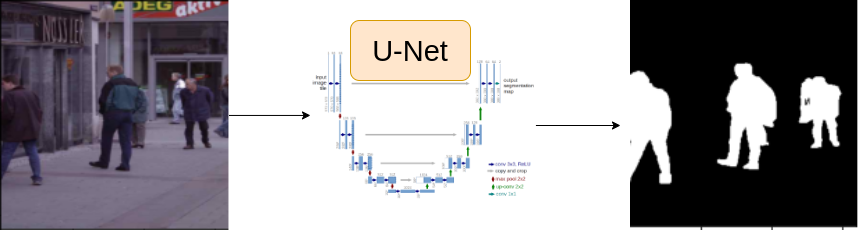

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
CSV_FILE="/content/Human-Segmentation-Dataset-master/train.csv"
DATA_DIR="/content"
DEVICE = 'cuda'
EPOCHS= 25
LR = 0.003
BATCH_SIZE = 16

IMG_SIZE = 320
ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row = df.iloc[8]
image_path = row.images
mask_path = row.masks
image  = cv2.imread(image_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)/255.0

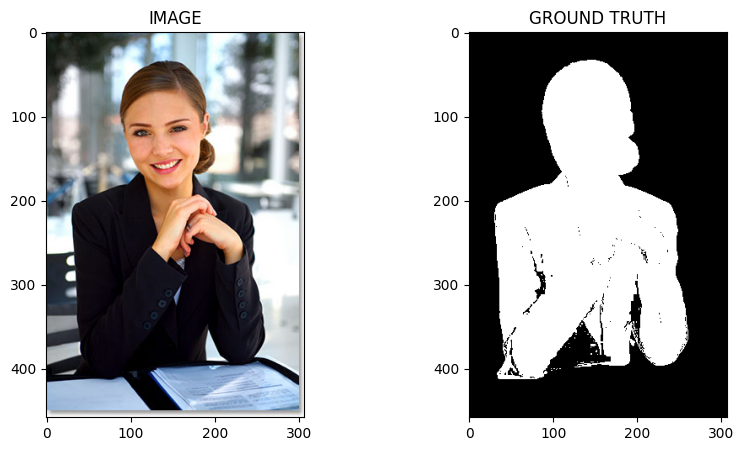

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df,valid_df= train_test_split(df,test_size = 0.2,random_state = 42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A


In [ ]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE,IMG_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE,IMG_SIZE)
  ])

# Task 4 : Create Custom Dataset

In [ ]:
#to get the image and mask im ac to index is the reason to create the custom dataset
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):
  def __init__(self,df,augmentation):
    self.df = df
    self.augmentation = augmentation
  def __len__(self):
    return len(self.df)
  def __getitem__(self,idx):
    row = self.df.iloc[idx]
    image_path=row.images
    mask_path = row.masks
    image = cv2.imread(image_path)
    image = cv2.resize(image,(IMG_SIZE,IMG_SIZE))

    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE) #SHAPE OF (h,w,c)
    mask = cv2.resize(mask,(IMG_SIZE,IMG_SIZE))
    mask = np.expand_dims(mask , axis = -1)

    if self.augmentation:
      data = self.augmentation(image = image ,mask = mask)
      image = data['image']
      mask = data['mask']

    #(h,w,c)--->(c,h,w) pytorch format
    image = np.transpose(image,(2,0,1)).astype(np.float32)
    mask = np.transpose(mask,(2,0,1)).astype(np.float32)

    image = torch.Tensor(image)/255.0
    mask = torch.round(torch.Tensor(mask))/255.0
    return image , mask




In [ ]:
trainset = SegmentationDataset(train_df,get_train_augs())
validset = SegmentationDataset(valid_df,get_valid_augs())


In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


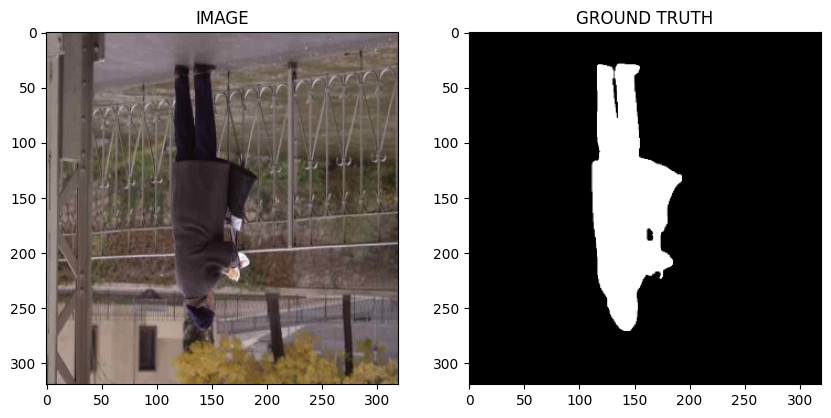

In [ ]:
idx = 4
image ,mask= trainset[idx]
helper.show_image(image,mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset,batch_size = BATCH_SIZE ,shuffle =True)
validloader = DataLoader(validset,batch_size = BATCH_SIZE,shuffle = True)

In [ ]:
print("total no. of batches in trainloader",len(trainloader))
print("total no. of batches in validloader",len(validloader))


total no. of batches in trainloader 15
total no. of batches in validloader 4


In [ ]:
for image,mask in(trainloader):
  break
print("One batch image shape",(image.shape))
print("One batch mask shape",(mask.shape))

One batch image shape torch.Size([16, 3, 320, 320])
One batch mask shape torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel,self).__init__()
    self.arc=smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels=3,
        classes = 1,
        activation = None

    )

  def forward(self,images,masks = None):
    logits = self.arc(images)
    if masks != None:
      loss1 = DiceLoss(mode= 'binary')(logits,masks)
      loss2 = nn.BCEWithLogitsLoss()(logits,masks)
      return logits,loss1 +loss2
    return logits

In [ ]:
model =   SegmentationModel()
model.to(DEVICE);

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:01<00:00, 17.2MB/s]


# Task 7 : Create Train and Validation Function

In [ ]:
def train_fn(data_loader,model,optimizer):
  model.train()
  total_loss = 0.0
  for images,masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)
    optimizer.zero_grad()
    logits,loss = model(images,masks)
    loss.backward()
    optimizer.step()
    total_loss+= loss.item()
  return total_loss/len(data_loader)


In [ ]:
def eval_fn(data_loader,model):
  model.eval()
  total_loss = 0.0
  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)
    # optimizer.zero_grad()
    logits,loss = model(images,masks)
    # loss.backward()
    # optimizer.step()
    total_loss+= loss.item()
  return total_loss/len(data_loader)


# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr = LR)

In [ ]:
best_valid_loss = np.Inf
for i in range(EPOCHS):
  train_loss = train_fn(trainloader,model,optimizer)
  valid_loss = eval_fn(validloader,model)
  if valid_loss <best_valid_loss:
    torch.save(model.state_dict(),'best_model.pt')
    print("saved model")
    best_valid_loss = valid_loss

  print(f"Epoch :{i+1} Train Loss:{train_loss}  Valid_Loss: {valid_loss}")



100%|██████████| 4/4 [00:00<00:00,  4.87it/s]


saved model
Epoch :1 Train Loss:0.7450704733530681  Valid_Loss: 0.8965619504451752


100%|██████████| 4/4 [00:00<00:00,  5.12it/s]


Epoch :2 Train Loss:0.42375561396280925  Valid_Loss: 1.7935213446617126


100%|██████████| 4/4 [00:00<00:00,  4.96it/s]


saved model
Epoch :3 Train Loss:0.3328683932622274  Valid_Loss: 0.3075995482504368


100%|██████████| 4/4 [00:00<00:00,  4.35it/s]


saved model
Epoch :4 Train Loss:0.2446490228176117  Valid_Loss: 0.26972248405218124


100%|██████████| 4/4 [00:00<00:00,  5.00it/s]


saved model
Epoch :5 Train Loss:0.2597377419471741  Valid_Loss: 0.2267567329108715


100%|██████████| 4/4 [00:00<00:00,  4.58it/s]


Epoch :6 Train Loss:0.22883425056934356  Valid_Loss: 0.27131716161966324


100%|██████████| 4/4 [00:00<00:00,  5.00it/s]


Epoch :7 Train Loss:0.2149374028046926  Valid_Loss: 0.2474379986524582


100%|██████████| 4/4 [00:00<00:00,  4.94it/s]


saved model
Epoch :8 Train Loss:0.2042938858270645  Valid_Loss: 0.17175239510834217


100%|██████████| 4/4 [00:00<00:00,  5.06it/s]


Epoch :9 Train Loss:0.20696579615275065  Valid_Loss: 0.18743706494569778


100%|██████████| 4/4 [00:00<00:00,  5.03it/s]


Epoch :10 Train Loss:0.16999629189570745  Valid_Loss: 0.2589170038700104


100%|██████████| 4/4 [00:00<00:00,  4.95it/s]


Epoch :11 Train Loss:0.17201977521181105  Valid_Loss: 0.25527413561940193


100%|██████████| 4/4 [00:00<00:00,  5.11it/s]


Epoch :12 Train Loss:0.13505503833293914  Valid_Loss: 0.23568040132522583


100%|██████████| 4/4 [00:00<00:00,  5.16it/s]


saved model
Epoch :13 Train Loss:0.13106022278467813  Valid_Loss: 0.17033316940069199


100%|██████████| 4/4 [00:00<00:00,  4.53it/s]


saved model
Epoch :14 Train Loss:0.12625553607940673  Valid_Loss: 0.1691283918917179


100%|██████████| 4/4 [00:00<00:00,  5.03it/s]


Epoch :15 Train Loss:0.1292198290427526  Valid_Loss: 0.1963934488594532


100%|██████████| 4/4 [00:00<00:00,  4.82it/s]


Epoch :16 Train Loss:0.1234703188141187  Valid_Loss: 0.20712284371256828


100%|██████████| 4/4 [00:00<00:00,  5.00it/s]


Epoch :17 Train Loss:0.12179490377505621  Valid_Loss: 0.1957414746284485


100%|██████████| 4/4 [00:00<00:00,  5.02it/s]


Epoch :18 Train Loss:0.1259129340449969  Valid_Loss: 0.19935337454080582


100%|██████████| 4/4 [00:01<00:00,  3.67it/s]


Epoch :19 Train Loss:0.13115969449281692  Valid_Loss: 0.1985236555337906


100%|██████████| 4/4 [00:00<00:00,  5.01it/s]


Epoch :20 Train Loss:0.10447613696257273  Valid_Loss: 0.1805797442793846


100%|██████████| 4/4 [00:00<00:00,  4.98it/s]


Epoch :21 Train Loss:0.1401808887720108  Valid_Loss: 0.18517706915736198


100%|██████████| 4/4 [00:00<00:00,  4.99it/s]


Epoch :22 Train Loss:0.11488095819950103  Valid_Loss: 0.1742238588631153


100%|██████████| 4/4 [00:00<00:00,  5.13it/s]


saved model
Epoch :23 Train Loss:0.09248589997490247  Valid_Loss: 0.16712239012122154


100%|██████████| 4/4 [00:01<00:00,  3.45it/s]


Epoch :24 Train Loss:0.11302167624235153  Valid_Loss: 0.19244230911135674


100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


saved model
Epoch :25 Train Loss:0.09235330273707708  Valid_Loss: 0.16258403472602367


# Task 9 : Inference

In [ ]:
idx = 10

#here we are going to use valid set as test set
model.load_state_dict(torch.load('/content/best_model.pt'))
image,mask = validset[idx]
logits_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask>0.5)*1.0

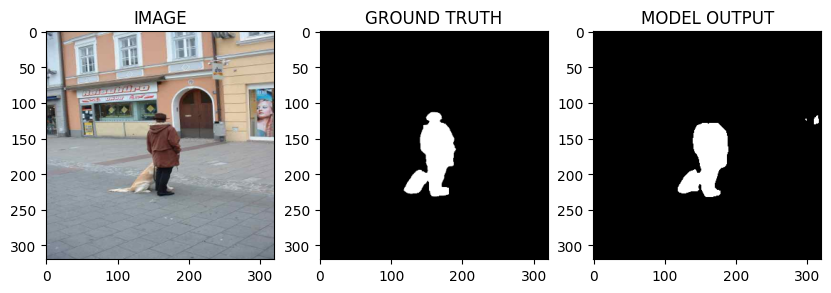

In [ ]:
helper.show_image(image,mask,pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya